In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Constants
kT = 1.0  # Boltzmann constant times temperature
epsilon = 1.0  # Depth of potential well
sigma = 1.0  # Finite distance where potential is zero
num_molecules = 20  # Number of molecules
box_size = 100  # Size of the simulation box
max_displacement = 0.1  # Maximum displacement in a single step

# Initialize positions in a 2D lattice
np.random.seed(0)
positions = np.random.rand(num_molecules, 2) * box_size

def lennard_jones_potential(r):
    """ Calculate Lennard-Jones potential for a distance r """
    r6 = (sigma / r)**6
    r12 = r6**2
    return 4 * epsilon * (r12 - r6)

def total_potential_energy(positions):
    # Compute all pairwise distances using broadcasting
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions
    distances = np.sqrt(np.sum(diff**2, axis=-1))

    # Avoid division by zero and self-interactions
    np.fill_diagonal(distances, np.inf)

    # Vectorized Lennard-Jones potential calculation
    return np.sum(lennard_jones_potential(distances)) / 2  # Divide by 2 to correct for double counting

def metropolis_step(positions, total_energy):
    """ Perform one step of the Metropolis algorithm """
    # Choose a random molecule
    molecule_idx = np.random.randint(num_molecules)
    old_position = positions[molecule_idx].copy()

    # Move the molecule to a new position
    displacement = (np.random.rand(2) - 0.5) * max_displacement
    positions[molecule_idx] += displacement

    # Apply periodic boundary conditions
    positions[molecule_idx] %= box_size

    # Calculate the energy change
    new_energy = total_potential_energy(positions)
    delta_energy = new_energy - total_energy

    # Metropolis criterion
    if delta_energy > 0 and -delta_energy / kT < np.log(np.random.rand()):
        # Reject the move, revert to the old position
        positions[molecule_idx] = old_position
    else:
        # Accept the move, update total energy
        total_energy = new_energy

    return positions, total_energy

# Initialize the total energy
total_energy = total_potential_energy(positions)
total_energy_history = [total_energy]

# Number of steps for the simulation
num_steps = 2000

# Perform the simulation
positions_history = [positions.copy()]
for step in range(1, num_steps * num_molecules):
    positions, total_energy = metropolis_step(positions, total_energy)
    positions_history.append(positions.copy())
    if (step % num_molecules == 0):
        total_energy_history.append(total_energy)

2000


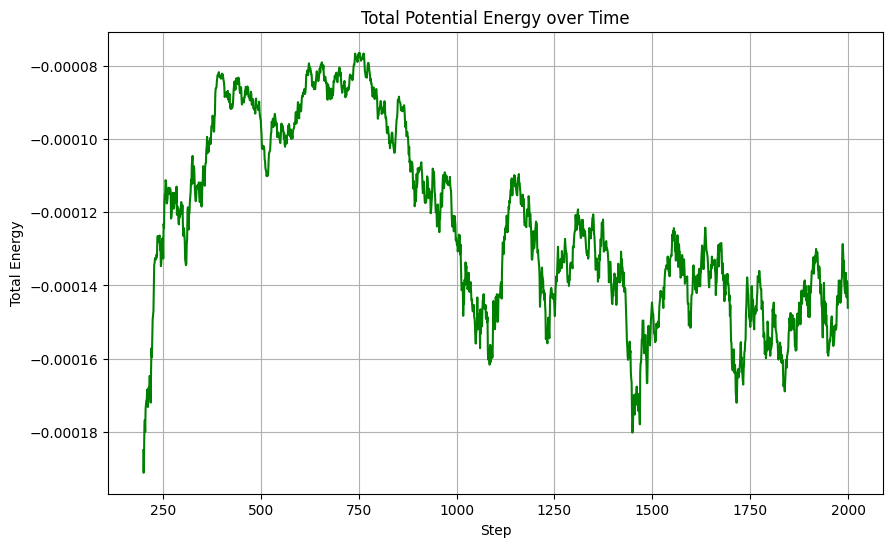

In [26]:
print(len(total_energy_history))
# Plotting the total energy over time
plt.figure(figsize=(10, 6))
plt.plot(range(200, num_steps), total_energy_history[200:], color='green')
plt.title("Total Potential Energy over Time")
plt.xlabel("Step")
plt.ylabel("Total Energy")
plt.grid(True)
plt.show()


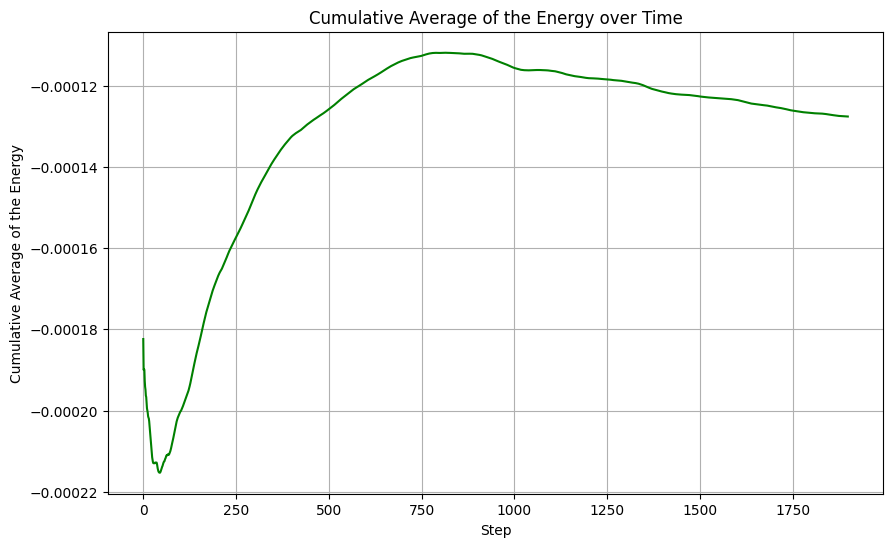

In [27]:
# Cumulative Average of the energy step by step
cum_avg_energy = np.cumsum(total_energy_history[100:]) / (np.arange(len(total_energy_history[100:])) + 1)

# Plotting the cumulative average of the energy over time
plt.figure(figsize=(10, 6))
plt.plot(cum_avg_energy, color='green')
plt.title("Cumulative Average of the Energy over Time")
plt.xlabel("Step")
plt.ylabel("Cumulative Average of the Energy")
plt.grid(True)
plt.show()

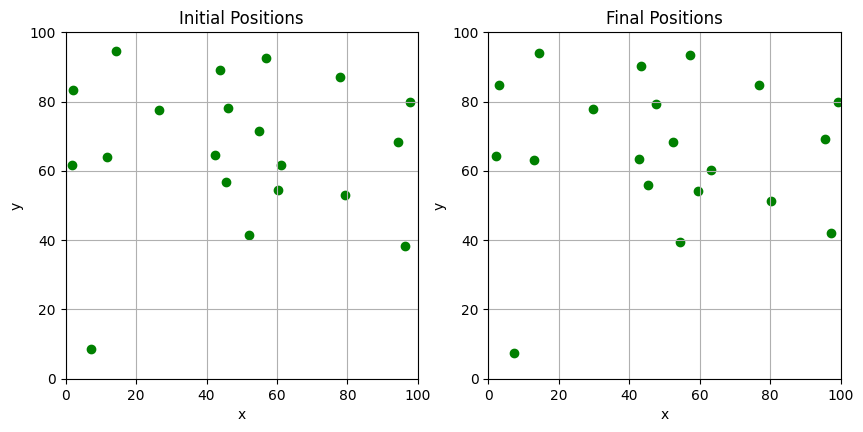

In [28]:
# Plot positions initial and final in two plots but in the same figure
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)
plt.scatter(positions_history[0][:, 0], positions_history[0][:, 1], color='green')
plt.title("Initial Positions")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.scatter(positions_history[-1][:, 0], positions_history[-1][:, 1], color='green')
plt.title("Final Positions")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.grid(True)
plt.show()

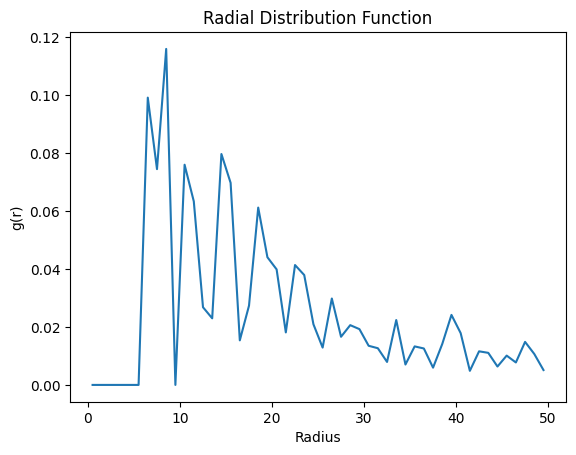

In [29]:
def compute_rdf(positions, num_bins=50, max_radius=box_size/2):
    distances = []
    for i in range(num_molecules):
        for j in range(i + 1, num_molecules):
            diff = positions[i] - positions[j]
            diff -= np.round(diff / box_size) * box_size  # Apply periodic boundary conditions
            distances.append(np.linalg.norm(diff))

    hist, bin_edges = np.histogram(distances, bins=num_bins, range=(0, max_radius), density=False)
    radii = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Normalize histogram to get RDF
    normalization = (num_molecules * (num_molecules - 1) / 2) * (4 * np.pi * radii**2) * (bin_edges[1] - bin_edges[0]) / box_size**2
    rdf = hist / normalization

    return radii, rdf

final_positions = positions_history[-1]
radii, rdf = compute_rdf(final_positions)

plt.plot(radii, rdf)
plt.xlabel('Radius')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()


In [30]:
# Compute the distance between all pairs of particles
distances = np.zeros((num_molecules, num_molecules))
for i in range(num_molecules):
    for j in range(i + 1, num_molecules):
        diff = final_positions[i] - final_positions[j]
        diff -= np.round(diff / box_size) * box_size  # Apply periodic boundary conditions
        distances[i, j] = np.linalg.norm(diff)
distances[distances == 0] = np.inf 

# Minimun distance between all pairs of particles
min_distance = np.min(distances)
print(min_distance)

6.227182755620347
